In [1]:
import pandas as pd
import numpy as np
import pickle

import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,8)

from itertools import combinations
import researchpy as rp

from sklearn.preprocessing import RobustScaler

from sklearn.preprocessing import OneHotEncoder 

from imblearn.over_sampling import RandomOverSampler

from imblearn.combine import SMOTETomek
from sklearn.model_selection import train_test_split


import warnings
warnings.filterwarnings('ignore')

from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity = "all"

pd.options.display.max_columns = None 

In [2]:
df = pd.read_pickle('../data/cardio_risk.pkl')
df.head()

,education,sex,age_category,BMI_category,is_smoking,BPMeds,prevalentStroke,prevalentHyp,diabetes,age,cigsPerDay,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,2.0,F,Senior Citizens,Overweight,YES,0.0,0,0,0,64.0,3.0,221.0,148.0,85.0,27.62,90.0,80.0,1
1,4.0,M,Middle-Aged Adults,Overweight,NO,0.0,0,1,0,36.0,0.0,212.0,168.0,98.0,29.77,72.0,75.0,0
2,1.0,F,Middle-Aged Adults,Normal Weight,YES,0.0,0,0,0,46.0,10.0,250.0,116.0,71.0,20.35,88.0,94.0,0
3,1.0,M,Middle-Aged Adults,Overweight,YES,0.0,0,1,0,50.0,20.0,233.0,158.0,88.0,28.26,68.0,94.0,1
4,1.0,F,Senior Citizens,Overweight,YES,0.0,0,0,0,64.0,30.0,241.0,136.5,85.0,26.42,70.0,77.0,0


In [3]:
df.index

RangeIndex(start=0, stop=3390, step=1)

In [4]:
response_var = 'TenYearCHD'

In our initial exploration, we found that the variables systolic blood pressure (sysBP) and diastolic blood pressure (diaBP) were strongly correlated. For our predictive model, we eliminate one of them. Due to medical studies indicating that sysBP is a more relevant risk factor for developing coronary heart disease, we will remove the variable diaBP.

In [5]:
df.drop(['diaBP'], axis = 1, inplace = True)

### FEATURE SCALING
----
We have several outliers, so we use the RobustScaler approach.

In [6]:
def scaling_with_robust_scaler(dataframe):

    num_dataframe = dataframe.select_dtypes(include = np.number)

    robust = RobustScaler()
    robust.fit(num_dataframe)
    X_robust = robust.transform(num_dataframe)
    numeric_robust = pd.DataFrame(X_robust, columns = num_dataframe.columns)
    dataframe[numeric_robust.columns] = numeric_robust

    return robust

In [7]:
robust_my_df = scaling_with_robust_scaler(df)

In [8]:
with open ('../data/robust_scaler.pkl', mode = 'wb') as f:
    pickle.dump(robust_my_df, f)

In [9]:
df.head()

,education,sex,age_category,BMI_category,is_smoking,BPMeds,prevalentStroke,prevalentHyp,diabetes,age,cigsPerDay,totChol,sysBP,BMI,heartRate,glucose,TenYearCHD
0,2.0,F,Senior Citizens,Overweight,YES,0.0,0,0,0,1.071429,0.15,-0.224138,0.722222,0.450931,1.000000,0.142857,1
1,4.0,M,Middle-Aged Adults,Overweight,NO,0.0,0,1,0,-0.928571,0.00,-0.379310,1.462963,0.883744,-0.200000,-0.214286,0
2,1.0,F,Middle-Aged Adults,Normal Weight,YES,0.0,0,0,0,-0.214286,0.50,0.275862,-0.462963,-1.012582,0.866667,1.142857,0
3,1.0,M,Middle-Aged Adults,Overweight,YES,0.0,0,1,0,0.071429,1.00,-0.017241,1.092593,0.579768,-0.466667,1.142857,1
4,1.0,F,Senior Citizens,Overweight,YES,0.0,0,0,0,1.071429,1.50,0.120690,0.296296,0.209361,-0.333333,-0.071429,0


### ENCODING
----
We investigate the correlation between categorical variables and the response variable to ascertain whether they impact the response variable, assigning them Ordinality accordingly.

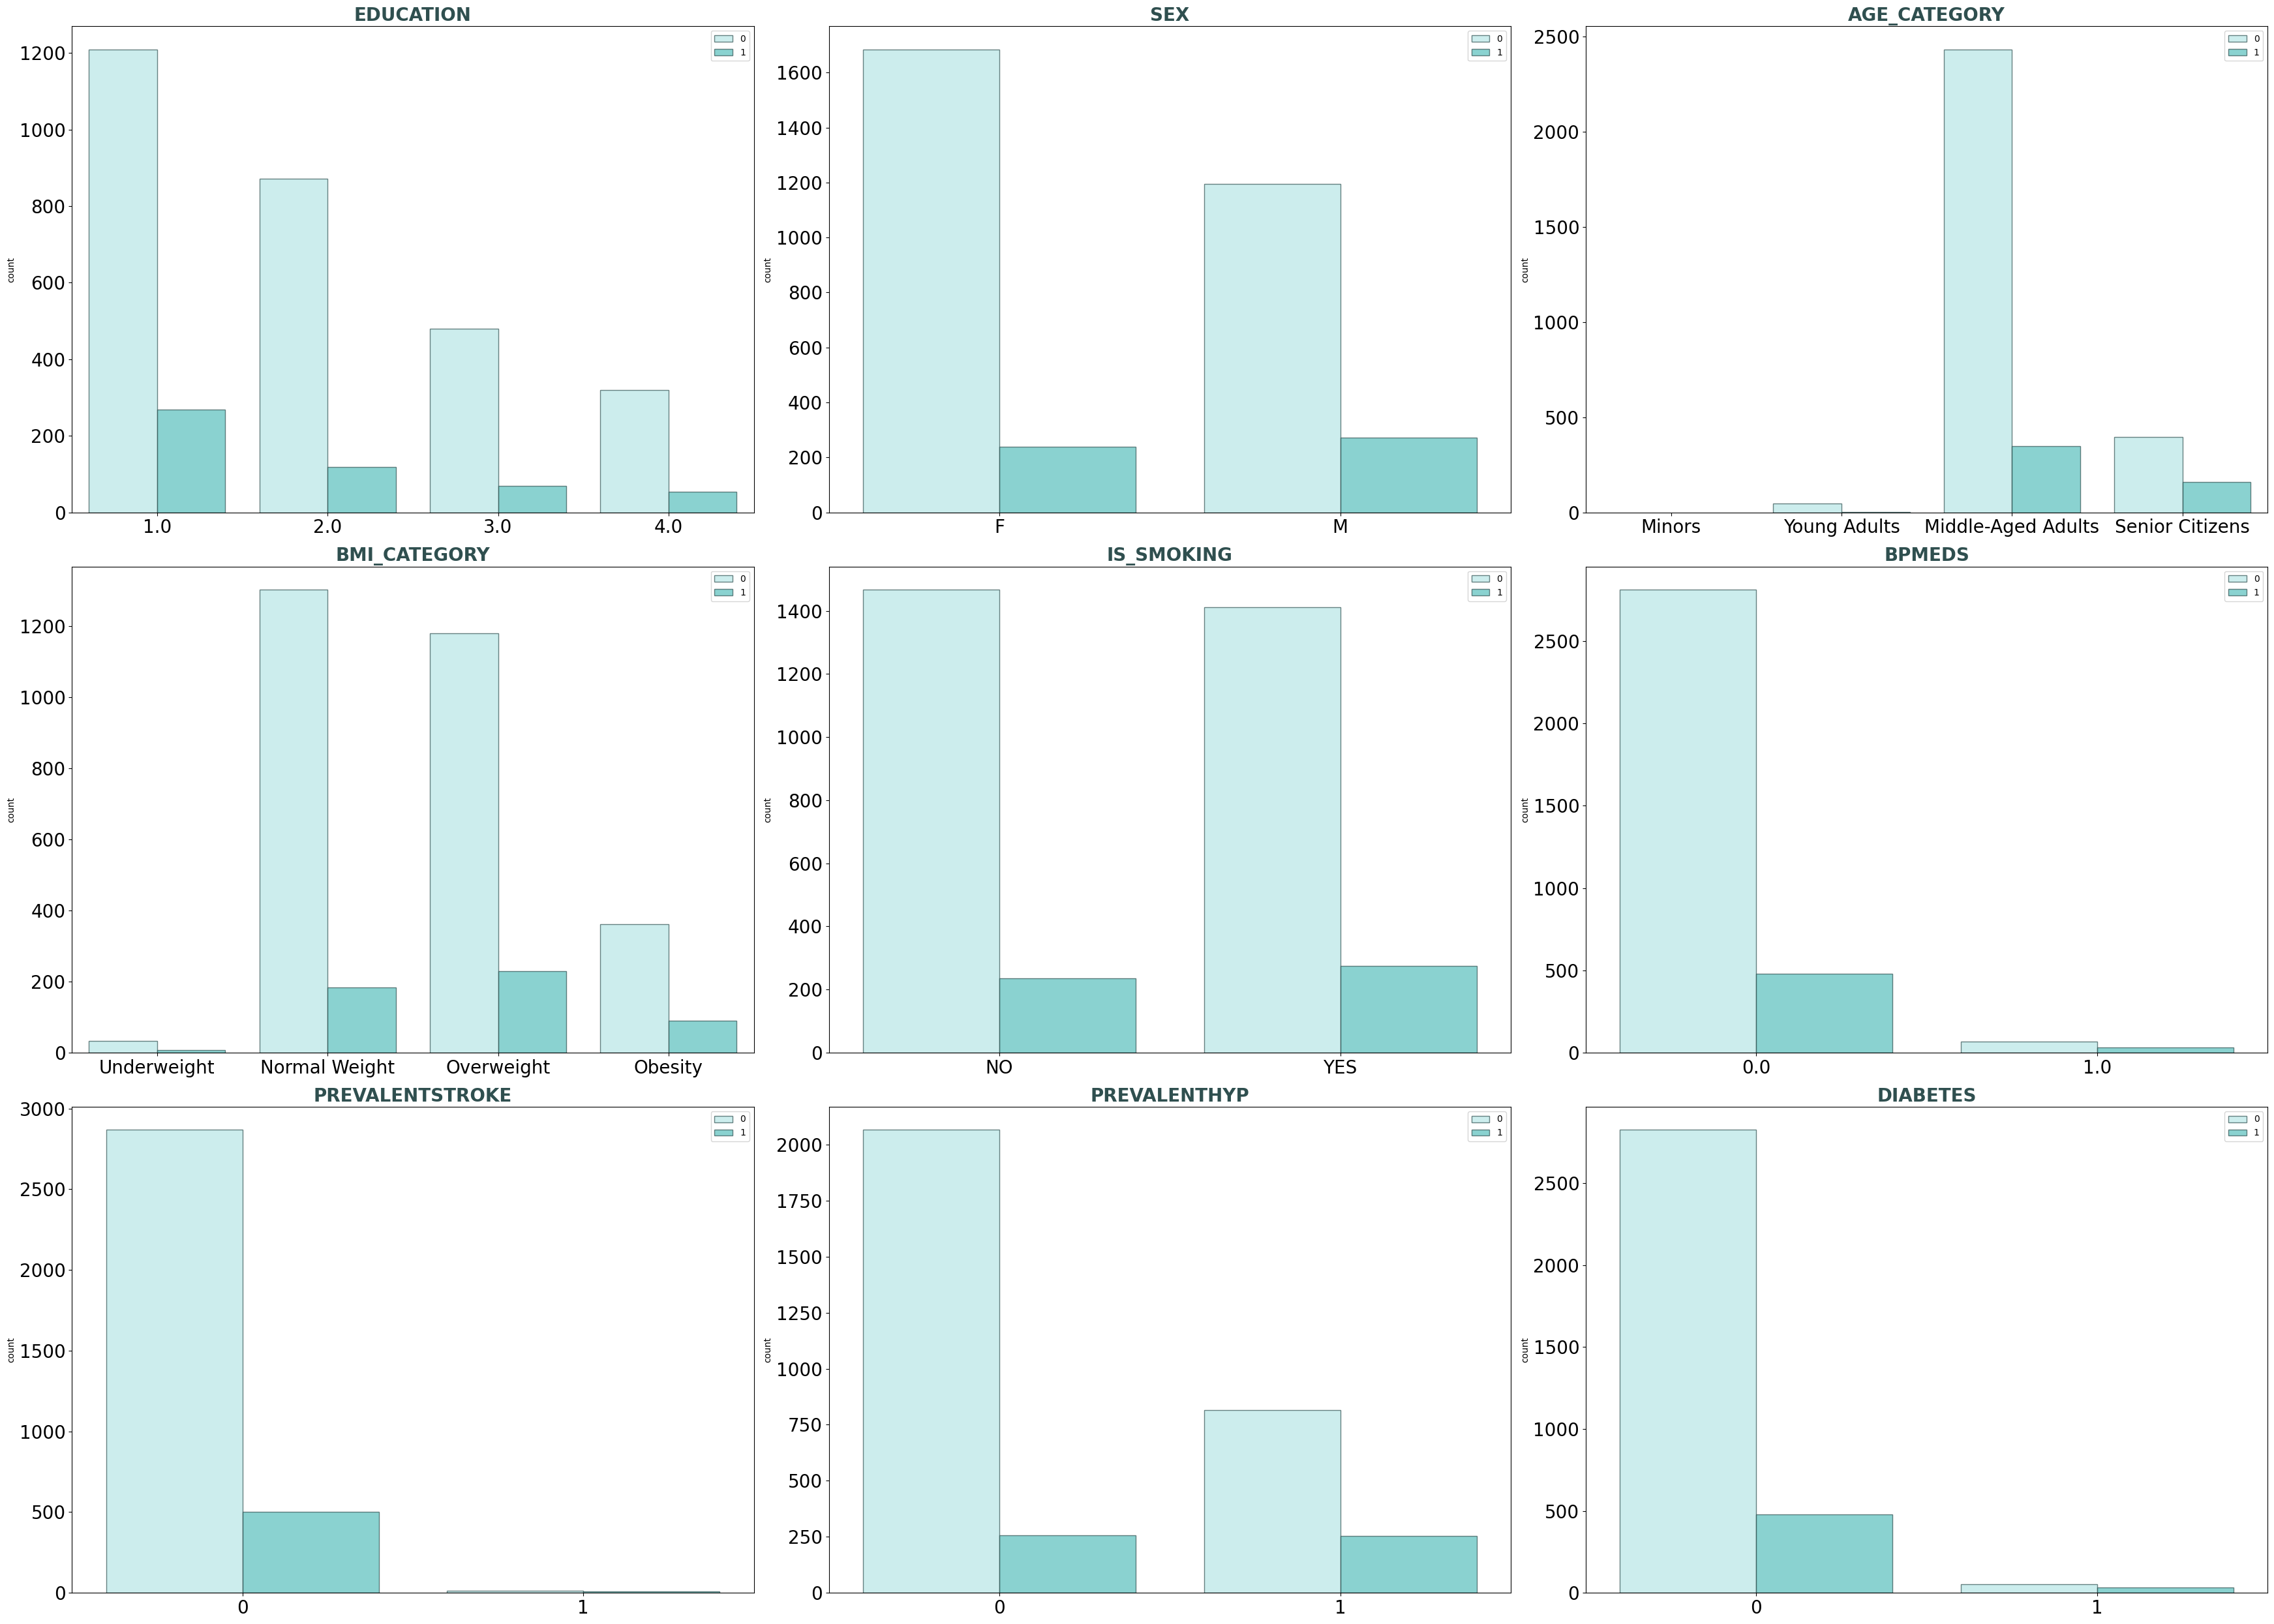

In [10]:
cat_df = df.select_dtypes(include = 'category')
cat_df.drop([response_var], axis = 1, inplace = True)

fig, axes = plt.subplots(nrows = 3, ncols = 3, figsize = (35, 25))
axes = axes.flat

my_palette_1 = ['paleturquoise', 'mediumturquoise']

for index, column in enumerate(cat_df): 
    sns.countplot(
        data = df,
        x = column,
        hue = response_var,
        alpha = 0.7, 
        palette = my_palette_1,
        edgecolor = 'darkslategrey',
        ax = axes[index])
    
    axes[index].set_title(column.upper(), fontsize = 20, color = 'darkslategray', fontweight = "bold")
    axes[index].tick_params(labelsize = 20)
    axes[index].set_xlabel('')
    axes[index].legend(loc= 'upper right')

fig.tight_layout();

In [11]:
# We examine the correlation between categorical variables and the response variable.

for col in cat_df.columns:
    crosstab= rp.crosstab(cat_df[col], df[response_var], prop = 'row')
    display(crosstab)

TenYearCHD              
TenYearCHD          0      1    All
education                          
1.0             81.80  18.20  100.0
2.0             88.08  11.92  100.0
3.0             87.25  12.75  100.0
4.0             85.52  14.48  100.0
All             84.93  15.07  100.0

TenYearCHD              
TenYearCHD          0      1    All
sex                                
F               87.57  12.43  100.0
M               81.46  18.54  100.0
All             84.93  15.07  100.0

TenYearCHD              
TenYearCHD                  0      1    All
age_category                               
Young Adults            96.00   4.00  100.0
Middle-Aged Adults      87.42  12.58  100.0
Senior Citizens         71.45  28.55  100.0
All                     84.93  15.07  100.0

TenYearCHD              
TenYearCHD             0      1    All
BMI_category                          
Underweight        80.49  19.51  100.0
Normal Weight      87.63  12.37  100.0
Overweight         83.70  16.30  100.0
Obesity            80.27  19.73  100.0
All                84.93  15.07  100.0

TenYearCHD              
TenYearCHD          0      1    All
is_smoking                         
NO              86.14  13.86  100.0
YES             83.70  16.30  100.0
All             84.93  15.07  100.0

TenYearCHD              
TenYearCHD          0      1    All
BPMeds                             
0.0             85.47  14.53  100.0
1.0             67.00  33.00  100.0
All             84.93  15.07  100.0

TenYearCHD              
TenYearCHD               0      1    All
prevalentStroke                         
0                    85.12  14.88  100.0
1                    54.55  45.45  100.0
All                  84.93  15.07  100.0

TenYearCHD              
TenYearCHD            0      1    All
prevalentHyp                         
0                 88.97  11.03  100.0
1                 76.15  23.85  100.0
All               84.93  15.07  100.0

TenYearCHD              
TenYearCHD          0      1    All
diabetes                           
0               85.53  14.47  100.0
1               62.07  37.93  100.0
All             84.93  15.07  100.0

##### CATEGORIES WITHOUT A SPECIFIC ORDER

In [12]:
def encoding_onehotencoder(dataframe, columns):

    oh = OneHotEncoder()

    for col in columns:
        transform = oh.fit_transform(dataframe[[col]])
        oh_dataframe = pd.DataFrame(transform.toarray())
        oh_dataframe.columns = oh.get_feature_names_out()
        dataframe = pd.concat([dataframe,oh_dataframe],axis=1)

    for col in columns:
        if col in columns:
            dataframe.drop([col], axis = 1, inplace = True)
        else:
            pass

    return oh

In [13]:
columns_without_order = ['education', 'is_smoking', 'sex']

In [14]:
oh_my_df = encoding_onehotencoder(df, columns_without_order)

In [15]:
with open ('../data/onehotencoder.pkl', mode = 'wb') as e:
    pickle.dump(oh_my_df, e)

##### CATEGORIES WITH A SPECIFIC ORDER

In [16]:
dict_bpmeds = {0.0: 0, 1.0: 2}
dict_prevalentstroke = {0.0: 0, 1.0: 3}
dict_diabetes = {0.0: 0, 1.0: 2}
dict_bmi_category = {'Normal Weight': 0, 'Overweight': 0.25, 'Underweight': 0.5, 'Obesity': 0.5}
dict_age_category = {'Young Adults': 0, 'Middle-Aged Adults': 0.5, 'Senior Citizens': 2}

In [17]:
columns_map = ['BPMeds', 'prevalentStroke', 'diabetes', 'BMI_category', 'age_category']
maps_encoding = [dict_bpmeds, dict_prevalentstroke, dict_diabetes, dict_bmi_category, dict_age_category ]

In [18]:
def encoding_map(dataframe, maps, columns):

    for map_encoding, col in zip(maps, columns):
        dataframe[col] = dataframe[col].map(map_encoding)

    return dataframe

In [19]:
df = encoding_map(df, maps_encoding, columns_map)

### RESAMPLING FOR CLASS IMBALANCE CORRECTION

-----

To rectify the class imbalance present in our dataset, we employ two approaches - RandomOverSampler and TokenSMOKE. Consequently, two distinct dataframes are generated. We are discarding the RandomUnderSampler approach as it would result in the loss of a significant amount of data.

In [20]:
def resampling_with_randomoversampler(dataframe, response_variable):

    y = dataframe[response_variable]
    X = dataframe.drop(response_variable, axis=1)

    over = RandomOverSampler()
    X_over, y_over = over.fit_resample(X, y)
    y_over.value_counts()

    print(y_over.value_counts())

    dataframe = pd.concat([X_over, y_over], axis = 1)

    return dataframe

In [21]:
df_over = resampling_with_randomoversampler(df, response_var)

TenYearCHD
0    2879
1    2879
Name: count, dtype: int64


In [22]:
def resampling_with_tokensmote(dataframe, response_variable):
    
    y = dataframe[response_variable]
    X = dataframe.drop(response_variable, axis=1)

    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7)

    os_us = SMOTETomek()

    X_train_resample, y_train_resample = os_us.fit_resample(X_train, y_train)

    print(y_train.value_counts())
    print(y_train_resample.value_counts())

    return dataframe


In [23]:
df_ts = resampling_with_tokensmote(df, response_var)

ValueError: could not convert string to float: 'M'

### SAVE CHANGES
----

In [ ]:
df_over.to_pickle('../data/cardio_processed_over.pkl')
df_ts.to_pickle('../data/cardio_processed_ts.pkl')